In [2]:
from kagglehub import KaggleDatasetAdapter
import os
import kagglehub
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

/Users/trungnvong/Desktop/grad_Fall25/data_cleaning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mimic_dataset = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "aminexdr/bhc-mimic-iv-summary", "BHC_MIMIC-IV.csv")

100%|██████████| 1.34G/1.34G [02:46<00:00, 8.68MB/s]


In [6]:
mimic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269516 entries, 0 to 269515
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   note_id        269516 non-null  object
 1   subject_id     269516 non-null  int64 
 2   hadm_id        269516 non-null  int64 
 3   note_type      269516 non-null  object
 4   note_seq       269516 non-null  int64 
 5   charttime      269516 non-null  object
 6   storetime      269516 non-null  object
 7   input          269516 non-null  object
 8   target         269516 non-null  object
 9   input_length   269516 non-null  int64 
 10  target_length  269516 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 22.6+ MB


In [7]:
mimic_dataset.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,input,target,input_length,target_length
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,summarize:\nChief Complaint: Worsening ABD dis...,"HCV cirrhosis cb ascites, hiv on ART, ho IVDU,...",675,148
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,summarize:\nChief Complaint: abdominal fullnes...,"with HIV on HAART, HCV cirrhosis with ascites ...",641,475
2,10000117-DS-21,10000117,22927623,DS,21,2181-11-15 00:00:00,2181-11-15 15:04:00,summarize:\nChief Complaint: dysphagia\nHistor...,Ms. is a with history of GERD who presents w...,259,70
3,10000117-DS-22,10000117,27988844,DS,22,2183-09-21 00:00:00,2183-09-29 16:23:00,summarize:\nChief Complaint: Left hip pain\nHi...,The patient presented to the emergency departm...,140,260
4,10000248-DS-10,10000248,20600184,DS,10,2192-11-30 00:00:00,2192-11-30 19:49:00,summarize:\nChief Complaint: Right flank bruis...,Mr. is a with history of mild FVIII deficien...,742,144


### Data Preprocessing Pipeline

Preprocess the `mimic_dataset` by handling missing values and duplicates, converting 'charttime' and 'storetime' to datetime objects, cleaning and tokenizing the 'input' and 'target' text columns, removing stopwords, and applying stemming or lemmatization. Afterward, visualize the distributions of 'input_length' and 'target_length' and provide a summary of all preprocessing steps and the current state of the dataset.

## Handle Missing Values and Duplicates
Check for and address any missing values or duplicate rows in the `mimic_dataset` to ensure data quality and integrity.


Display the number of missing values for each column and the total number of duplicate rows in the `mimic_dataset`. If duplicates are found, then remove them from the dataset.



In [8]:
print("Missing values per column:")
print(mimic_dataset.isnull().sum())

duplicate_rows_count = mimic_dataset.duplicated().sum()
print(f"\nTotal duplicate rows: {duplicate_rows_count}")

if duplicate_rows_count > 0:
    mimic_dataset.drop_duplicates(inplace=True)
    print("Duplicate rows removed.")
    print(f"New number of rows after removing duplicates: {len(mimic_dataset)}")
else:
    print("No duplicate rows found.")

Missing values per column:
note_id          0
subject_id       0
hadm_id          0
note_type        0
note_seq         0
charttime        0
storetime        0
input            0
target           0
input_length     0
target_length    0
dtype: int64

Total duplicate rows: 0
No duplicate rows found.


## Convert Datetime Columns
Convert the 'charttime' and 'storetime' columns from object type to datetime objects to enable time-based analysis and feature extraction.


Convert the 'charttime' and 'storetime' columns in the `mimic_dataset` to datetime objects using `pd.to_datetime()`, coercing any parsing errors to `NaT` to ensure data type consistency for time-based analysis.



In [9]:
mimic_dataset['charttime'] = pd.to_datetime(mimic_dataset['charttime'], errors='coerce')
mimic_dataset['storetime'] = pd.to_datetime(mimic_dataset['storetime'], errors='coerce')

print("Data types after converting 'charttime' and 'storetime':")
mimic_dataset.info()

Data types after converting 'charttime' and 'storetime':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269516 entries, 0 to 269515
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   note_id        269516 non-null  object        
 1   subject_id     269516 non-null  int64         
 2   hadm_id        269516 non-null  int64         
 3   note_type      269516 non-null  object        
 4   note_seq       269516 non-null  int64         
 5   charttime      269516 non-null  datetime64[ns]
 6   storetime      269516 non-null  datetime64[ns]
 7   input          269516 non-null  object        
 8   target         269516 non-null  object        
 9   input_length   269516 non-null  int64         
 10  target_length  269516 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 22.6+ MB


## Clean Text Data
Perform comprehensive cleaning on the 'input' and 'target' text columns by lowercasing, removing special characters, numbers, and excess whitespace.


In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text) # Remove special characters, keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

print("Applying text cleaning to 'input' column...")
mimic_dataset['input'] = mimic_dataset['input'].apply(clean_text)
print("Applying text cleaning to 'target' column...")
mimic_dataset['target'] = mimic_dataset['target'].apply(clean_text)

print("\nFirst 5 rows of cleaned 'input' column:")
print(mimic_dataset['input'].head())
print("\nFirst 5 rows of cleaned 'target' column:")
print(mimic_dataset['target'].head())

Applying text cleaning to 'input' column...
Applying text cleaning to 'target' column...

First 5 rows of cleaned 'input' column:
0    summarize chief complaint worsening abd disten...
1    summarize chief complaint abdominal fullness a...
2    summarize chief complaint dysphagia history of...
3    summarize chief complaint left hip pain histor...
4    summarize chief complaint right flank bruising...
Name: input, dtype: object

First 5 rows of cleaned 'target' column:
0    hcv cirrhosis cb ascites hiv on art ho ivdu co...
1    with hiv on haart hcv cirrhosis with ascites a...
2    ms is a with history of gerd who presents with...
3    the patient presented to the emergency departm...
4    mr is a with history of mild fviii deficiency ...
Name: target, dtype: object


## Tokenize Text Data
Tokenize the cleaned 'input' and 'target' text into individual words, which is a fundamental step for many natural language processing tasks.


To perform tokenization, define a function to tokenize text using `nltk.word_tokenize` and apply it to both the 'input' and 'target' columns to create new tokenized columns, displaying the first few rows to confirm the operation.



In [11]:
nltk.download('punkt')
nltk.download('punkt_tab') # Explicitly download punkt_tab

def tokenize_text(text):
    return nltk.word_tokenize(text)

print("Tokenizing 'input' column...")
mimic_dataset['tokenized_input'] = mimic_dataset['input'].apply(tokenize_text)
print("Tokenizing 'target' column...")
mimic_dataset['tokenized_target'] = mimic_dataset['target'].apply(tokenize_text)

print("\nFirst 5 rows of 'tokenized_input' column:")
print(mimic_dataset['tokenized_input'].head())
print("\nFirst 5 rows of 'tokenized_target' column:")
print(mimic_dataset['tokenized_target'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/trungnvong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/trungnvong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokenizing 'input' column...
Tokenizing 'target' column...

First 5 rows of 'tokenized_input' column:
0    [summarize, chief, complaint, worsening, abd, ...
1    [summarize, chief, complaint, abdominal, fulln...
2    [summarize, chief, complaint, dysphagia, histo...
3    [summarize, chief, complaint, left, hip, pain,...
4    [summarize, chief, complaint, right, flank, br...
Name: tokenized_input, dtype: object

First 5 rows of 'tokenized_target' column:
0    [hcv, cirrhosis, cb, ascites, hiv, on, art, ho...
1    [with, hiv, on, haart, hcv, cirrhosis, with, a...
2    [ms, is, a, with, history, of, gerd, who, pres...
3    [the, patient, presented, to, the, emergency, ...
4    [mr, is, a, with, history, of, mild, fviii, de...
Name: tokenized_target, dtype: object


## Remove Stopwords and Stem/Lemmatize Text

Remove common stopwords from the tokenized 'input' and 'target' text and apply stemming or lemmatization to reduce words to their base forms, further preparing the text for analysis.


In [12]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Create a set of English stopwords for efficient lookup
stop_words = set(stopwords.words('english'))

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    lemmas = []
    for token in tokens:
        if token not in stop_words:
            lemmas.append(lemmatizer.lemmatize(token))
    return lemmas

print("Applying lemmatization and stopword removal to 'tokenized_input' column...")
mimic_dataset['lemmatized_input'] = mimic_dataset['tokenized_input'].apply(lemmatize_text)
print("Applying lemmatization and stopword removal to 'tokenized_target' column...")
mimic_dataset['lemmatized_target'] = mimic_dataset['tokenized_target'].apply(lemmatize_text)

print("\nFirst 5 rows of 'lemmatized_input' column:")
print(mimic_dataset['lemmatized_input'].head())
print("\nFirst 5 rows of 'lemmatized_target' column:")
print(mimic_dataset['lemmatized_target'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trungnvong/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/trungnvong/nltk_data...


Applying lemmatization and stopword removal to 'tokenized_input' column...
Applying lemmatization and stopword removal to 'tokenized_target' column...

First 5 rows of 'lemmatized_input' column:
0    [summarize, chief, complaint, worsening, abd, ...
1    [summarize, chief, complaint, abdominal, fulln...
2    [summarize, chief, complaint, dysphagia, histo...
3    [summarize, chief, complaint, left, hip, pain,...
4    [summarize, chief, complaint, right, flank, br...
Name: lemmatized_input, dtype: object

First 5 rows of 'lemmatized_target' column:
0    [hcv, cirrhosis, cb, ascites, hiv, art, ho, iv...
1    [hiv, haart, hcv, cirrhosis, ascites, ho, ivdu...
2    [m, history, gerd, present, subacute, worsenin...
3    [patient, presented, emergency, department, ev...
4    [mr, history, mild, fviii, deficiency, present...
Name: lemmatized_target, dtype: object


### Remove Rare Words
Identify and remove rare words from the tokenized 'input' and 'target' text to reduce noise and improve model performance.

In [18]:
from collections import Counter

word_counts = Counter([t for tokens in mimic_dataset['lemmatized_input'] for t in tokens])
rare_words = {w for w, c in word_counts.items() if c <= 2}

def remove_rare(tokens):
    return [t for t in tokens if t not in rare_words]

mimic_dataset['filtered_input'] = mimic_dataset['lemmatized_input'].apply(remove_rare)

### Join Tokens Back to Text instead of keeping as list
After tokenization, stopword removal, and stemming/lemmatization, join the tokens back into strings for both 'input' and 'target' columns

In [19]:
mimic_dataset['final_input'] = mimic_dataset['lemmatized_input'].apply(lambda x: ' '.join(x))
mimic_dataset['final_target'] = mimic_dataset['lemmatized_target'].apply(lambda x: ' '.join(x))

### Visualize Text Length Distributions
Visualize the distributions of 'input_length' and 'target_length' to understand the characteristics of the text lengths in dataset. 

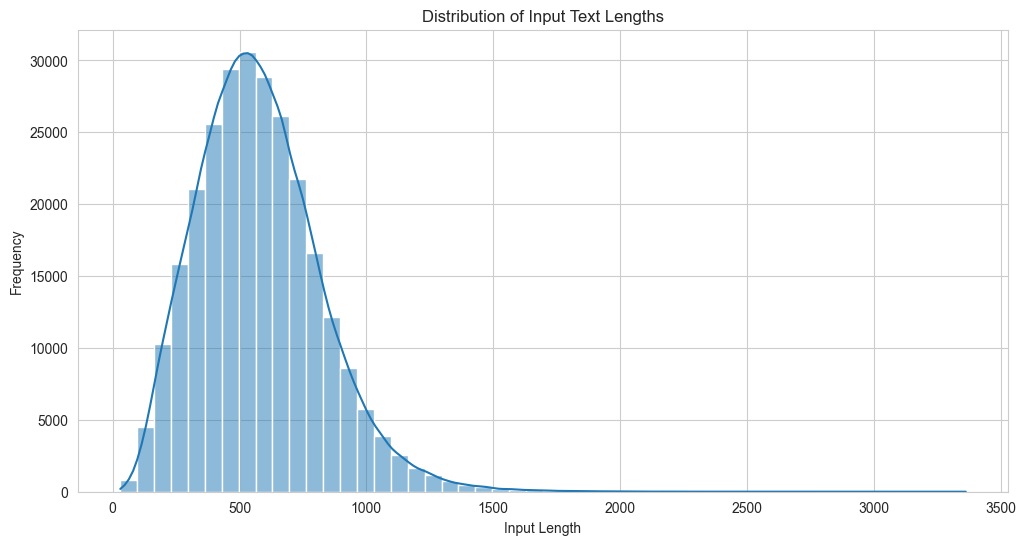

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(mimic_dataset['input_length'], bins=50, kde=True)
plt.title('Distribution of Input Text Lengths')
plt.xlabel('Input Length')
plt.ylabel('Frequency')
plt.show()

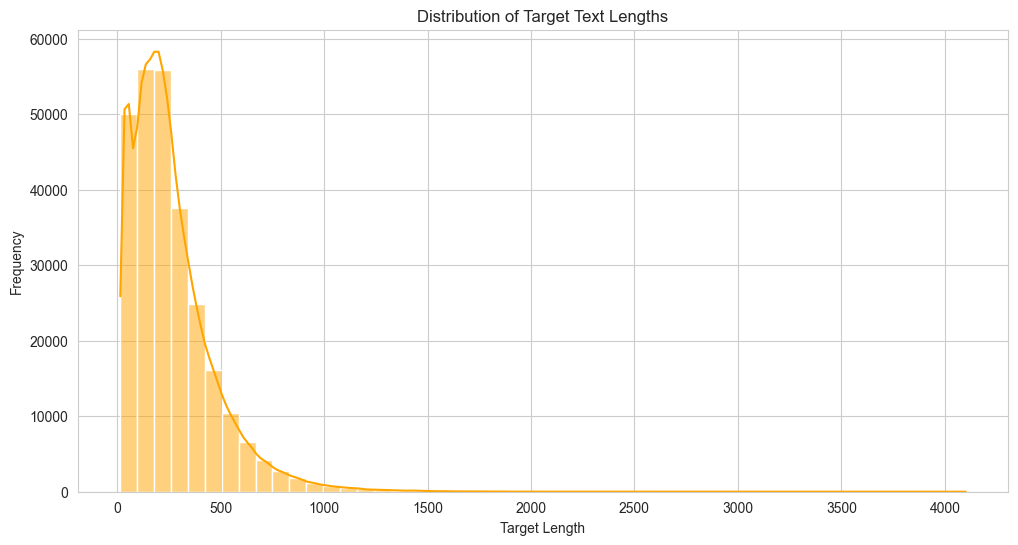

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(mimic_dataset['target_length'], bins=50, kde=True, color='orange')
plt.title('Distribution of Target Text Lengths')
plt.xlabel('Target Length')
plt.ylabel('Frequency')
plt.show()

In [22]:
print("\n### Current State of mimic_dataset:\n")
mimic_dataset.info()
print("\nFirst 5 rows of the dataset with new processed columns:")
display(mimic_dataset[['input', 'tokenized_input', 'lemmatized_input', 'filtered_input', 'final_input', 'target', 'tokenized_target', 'lemmatized_target', 'final_target']].head())


### Current State of mimic_dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269516 entries, 0 to 269515
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   note_id            269516 non-null  object        
 1   subject_id         269516 non-null  int64         
 2   hadm_id            269516 non-null  int64         
 3   note_type          269516 non-null  object        
 4   note_seq           269516 non-null  int64         
 5   charttime          269516 non-null  datetime64[ns]
 6   storetime          269516 non-null  datetime64[ns]
 7   input              269516 non-null  object        
 8   target             269516 non-null  object        
 9   input_length       269516 non-null  int64         
 10  target_length      269516 non-null  int64         
 11  tokenized_input    269516 non-null  object        
 12  tokenized_target   269516 non-null  object        
 13  lemmat

,input,tokenized_input,lemmatized_input,filtered_input,final_input,target,tokenized_target,lemmatized_target,final_target
0,summarize chief complaint worsening abd disten...,"[summarize, chief, complaint, worsening, abd, ...","[summarize, chief, complaint, worsening, abd, ...","[summarize, chief, complaint, worsening, abd, ...",summarize chief complaint worsening abd disten...,hcv cirrhosis cb ascites hiv on art ho ivdu co...,"[hcv, cirrhosis, cb, ascites, hiv, on, art, ho...","[hcv, cirrhosis, cb, ascites, hiv, art, ho, iv...",hcv cirrhosis cb ascites hiv art ho ivdu copd ...
1,summarize chief complaint abdominal fullness a...,"[summarize, chief, complaint, abdominal, fulln...","[summarize, chief, complaint, abdominal, fulln...","[summarize, chief, complaint, abdominal, fulln...",summarize chief complaint abdominal fullness d...,with hiv on haart hcv cirrhosis with ascites a...,"[with, hiv, on, haart, hcv, cirrhosis, with, a...","[hiv, haart, hcv, cirrhosis, ascites, ho, ivdu...",hiv haart hcv cirrhosis ascites ho ivdu copd b...
2,summarize chief complaint dysphagia history of...,"[summarize, chief, complaint, dysphagia, histo...","[summarize, chief, complaint, dysphagia, histo...","[summarize, chief, complaint, dysphagia, histo...",summarize chief complaint dysphagia history pr...,ms is a with history of gerd who presents with...,"[ms, is, a, with, history, of, gerd, who, pres...","[m, history, gerd, present, subacute, worsenin...",m history gerd present subacute worsening dysp...
3,summarize chief complaint left hip pain histor...,"[summarize, chief, complaint, left, hip, pain,...","[summarize, chief, complaint, left, hip, pain,...","[summarize, chief, complaint, left, hip, pain,...",summarize chief complaint left hip pain histor...,the patient presented to the emergency departm...,"[the, patient, presented, to, the, emergency, ...","[patient, presented, emergency, department, ev...",patient presented emergency department evaluat...
4,summarize chief complaint right flank bruising...,"[summarize, chief, complaint, right, flank, br...","[summarize, chief, complaint, right, flank, br...","[summarize, chief, complaint, right, flank, br...",summarize chief complaint right flank bruising...,mr is a with history of mild fviii deficiency ...,"[mr, is, a, with, history, of, mild, fviii, de...","[mr, history, mild, fviii, deficiency, present...",mr history mild fviii deficiency present snowb...


In [29]:
display(mimic_dataset[['input', 'lemmatized_input','target', 'lemmatized_target']].head())

,input,lemmatized_input,target,lemmatized_target
0,summarize chief complaint worsening abd disten...,"[summarize, chief, complaint, worsening, abd, ...",hcv cirrhosis cb ascites hiv on art ho ivdu co...,"[hcv, cirrhosis, cb, ascites, hiv, art, ho, iv..."
1,summarize chief complaint abdominal fullness a...,"[summarize, chief, complaint, abdominal, fulln...",with hiv on haart hcv cirrhosis with ascites a...,"[hiv, haart, hcv, cirrhosis, ascites, ho, ivdu..."
2,summarize chief complaint dysphagia history of...,"[summarize, chief, complaint, dysphagia, histo...",ms is a with history of gerd who presents with...,"[m, history, gerd, present, subacute, worsenin..."
3,summarize chief complaint left hip pain histor...,"[summarize, chief, complaint, left, hip, pain,...",the patient presented to the emergency departm...,"[patient, presented, emergency, department, ev..."
4,summarize chief complaint right flank bruising...,"[summarize, chief, complaint, right, flank, br...",mr is a with history of mild fviii deficiency ...,"[mr, history, mild, fviii, deficiency, present..."


In [23]:
mimic_dataset.to_csv("mimic_cleaned_full.csv", index=False)

In [24]:
mimic_dataset[['final_input', 'final_target']].to_csv(
    "mimic_cleaned_text_only.csv",
    index=False
)

In [26]:
cols = [
    "input", "target",
    "filtered_input",
    "tokenized_input", "tokenized_target",
    "lemmatized_input", "lemmatized_target",
    "final_input", "final_target"
]
mimic_dataset[cols].to_csv("mimic_preprocessing_steps.csv", index=False)